In [0]:
%tensorflow_version 2.x

from tensorflow import math as mt
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import keras
#from keras.layers import LSTM, Dense, Flatten, Dropout, Activation, GRU, TimeDistributed, InputLayer, Conv1D, Conv2D, Conv3D
#from keras.models import Sequential
#from keras.callbacks import EarlyStopping
# from keras.optimizers import Adam

from google.colab import drive
drive.mount("/content/gdrive/")

TensorFlow 2.x selected.
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Using TensorFlow backend.


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/AutoML/CNN/TV')

from x_pipeline import XPipeline
from y_pipeline import YPipeline

In [0]:
X_train = pd.read_csv(
    'gdrive/My Drive/AutoML/data/X_train_6GWGSxz.csv',
)
X_train.set_index("time_step", inplace=True)
Y_train = pd.read_csv(
    'gdrive/My Drive/AutoML/data/y_train_2G60rOL.csv',
)
Y_train.set_index("time_step", inplace=True)

px = XPipeline()
py = YPipeline()

In [0]:
X_train.columns

Index(['consumption', 'visibility', 'temperature', 'humidity', 'humidex',
       'windchill', 'wind', 'pressure', 'Unnamed: 9'],
      dtype='object')

In [0]:
pd.set_option('display.max_columns', None)

## Preprocessing

In [0]:
print('Start of first transform')
x = px.fit(X_train)
x = px.transform(X_train)
print('End of first transform')
y = py.fit(Y_train)
y = py.transform(Y_train)
print('Second transform')
x_train, y_train = x[:321000, :, :], y[:321000]
x_valid, y_valid = x[321000:, :, :], y[321000:]

Start of first transform
End of first transform
Second transform


In [0]:
x.shape

(401759, 120, 1)

In [0]:
print(f"x_train shape is {x_train.shape}")
print(f"x_valid shape is {x_valid.shape}")

x_train shape is (321000, 120, 1)
x_valid shape is (80759, 120, 1)


## CNN

In [0]:
# Leo's
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=[120, 1]))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=6, padding="valid",
                              activation="relu"))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="valid",
                              activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(filters=48, kernel_size=3, padding="valid",
                              activation="relu"))
model.add(tf.keras.layers.Conv1D(filters=48, kernel_size=3, padding="valid",
                              activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding="valid",
                              activation="relu"))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 115, 32)           224       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 113, 32)           3104      
_________________________________________________________________
batch_normalization (BatchNo (None, 113, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 113, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 111, 48)           4656      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 109, 48)           6960      
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 48)           1

Metric: Mean Squared Error. Same as minimizing the Metric on the platform.

In [0]:
model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adam())
history = model.fit(x, y, epochs=4)
# history = model.fit(x_train, y_train, epochs=4,
#                     validation_data=(x_valid, y_valid))

Train on 401759 samples
Epoch 1/4
401759/401759 [==============================] - 75s 186us/sample - loss: 211.6702
Epoch 2/4
401759/401759 [==============================] - 67s 166us/sample - loss: 177.0566
Epoch 3/4
401759/401759 [==============================] - 66s 163us/sample - loss: 153.6242
Epoch 4/4
401759/401759 [==============================] - 65s 162us/sample - loss: 134.1466


In [0]:
# model.save("/content/gdrive/My Drive/AutoML/CNN/TV/Leo_4_120.h5")

In [0]:
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.plot(history.history['loss'], label = 'Training loss')

plt.title('Evolution of the loss over time')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

KeyError: ignored

In [0]:
pred_val = model.predict(x_valid)

In [0]:
pred_val[pred_val<0] = 0

### Evaluating Performance

In [0]:
pred = pd.DataFrame(pred_val, columns=["TV"])

In [0]:
def nilm_metric(y_true, y_pred):
        score = 0.0
        score += math.sqrt(sum((y_pred - y_true) ** 2) / len(y_true)) * 14.57
        score /= 74.86
        return score

In [0]:
nilm_metric(y_valid.values, pred_val)

2.0947698131116392

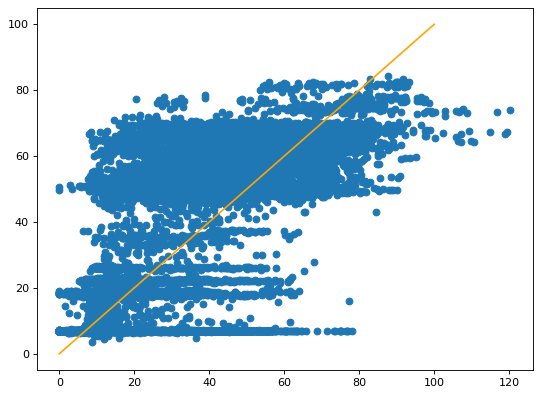

In [0]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(pred_val, y_valid)
plt.plot(np.linspace(0,100), np.linspace(0,100), c="orange")
plt.show()

### submission

In [0]:
X_test = pd.read_csv(
    'gdrive/My Drive/AutoML/data/X_test_c2uBt2s.csv',
)
time = X_test["time_step"]
X_test.set_index("time_step", inplace=True)

In [0]:
x_test = px.transform(X_test)

In [0]:
pred = model.predict(x_test)
pred[pred<0] = 0
pred = pd.DataFrame(pred, columns=["TV"])

In [0]:
pred = pd.concat([time, pred], axis=1)

In [0]:
# pred.fillna(method="ffill", inplace=True)

In [0]:
pred.to_csv("gdrive/My Drive/AutoML/CNN/TV/TV.csv", index=False)